# Longshot bias in esports gaming

What this notebook does: in sports betting you will often find inefficiencies in the odds market. Smaller or bigger odds are winning way more or way less often than they should, according to their inherent probabilites. For example you bet on your favorite team with odds of 1.2 which equals to a 83,3% chance to win, assuming the bookies know how and why they set the odds to 1.2. Often in underdeveloped sports like esports, the odds are way off which leads to opportunities to use this advantage. 

Longshot odds are often way too high calculated as minor leagues' marktets are not efficient. Betting only on the longshot odds (the bigger ones) may lead to a substantial profit as the odds are paying out more than they should according to the underlying probabilites.
Let's have a look at the numbers.

### Let's import the packages and data from Excel file

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns #plots plots
import matplotlib.pylab as plt
import warnings #ignores some warnings that are not relevant here
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_excel("WhichOddWins.xlsx", sheet_name="HA_Bias_2021", skiprows=[0]) # reads in the data from an xls-file

### Preparing the data

In [4]:
df = df[["Div", "Date", "WinningOdd", "STD", "MAX", "MIN", "StakeBig", "WinOnBig", "StakeSmall", "WinOnSmall"]] # keeps only the relevant columns

In [5]:
df['Year'] = pd.DatetimeIndex(df['Date']).year # ignores the day and month since they are not needed

In [6]:
df["ProfitOnBig"] = df["WinOnBig"] - df["StakeBig"] #calculates the profit from Wins and Stakes for bets on bigger odds

In [7]:
df["ProfitOnSmall"] = df["WinOnSmall"] - df["StakeSmall"] #calculates the profit from Wins and Stakes for bets in smaller odds

In [8]:
df = df.dropna() # filters out NAs

In [9]:
# list of thresholds of standard deviations for filtering the data 
thresholds = [0.0, 0.7, 1.0, 1.5, 2.0, 2.5, 3.0, 5.0]

In [10]:
# Sanity check
df.tail()

,Div,Date,WinningOdd,STD,MAX,MIN,StakeBig,WinOnBig,StakeSmall,WinOnSmall,Year,ProfitOnBig,ProfitOnSmall
12266,starcraft-2-global-starcraft-ii-league-season-1,2021-04-12,Small,0.930,3.18,1.32,3.646789,0.000000,10.312500,13.612500,2021,-3.646789,3.300000
12267,starcraft-2-global-starcraft-ii-league-season-1,2021-04-08,Big,0.705,2.81,1.40,3.881215,10.906215,8.750000,0.000000,2021,7.025000,-8.750000
12268,starcraft-2-global-starcraft-ii-league-season-1,2021-04-08,Small,0.600,2.64,1.44,4.024390,0.000000,8.181818,11.781818,2021,-4.024390,3.600000
12269,starcraft-2-global-starcraft-ii-league-season-1,2021-04-05,Big,0.470,2.45,1.51,4.224138,10.349138,7.401961,0.000000,2021,6.125000,-7.401961
12270,starcraft-2-global-starcraft-ii-league-season-1,2021-04-05,Big,1.290,3.82,1.24,3.386525,12.936525,12.916667,0.000000,2021,9.550000,-12.916667


In [11]:
# Sanity check again
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12271 entries, 0 to 12270
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Div            12271 non-null  object        
 1   Date           12271 non-null  datetime64[ns]
 2   WinningOdd     12271 non-null  object        
 3   STD            12271 non-null  float64       
 4   MAX            12271 non-null  float64       
 5   MIN            12271 non-null  float64       
 6   StakeBig       12271 non-null  float64       
 7   WinOnBig       12271 non-null  float64       
 8   StakeSmall     12271 non-null  float64       
 9   WinOnSmall     12271 non-null  float64       
 10  Year           12271 non-null  int64         
 11  ProfitOnBig    12271 non-null  float64       
 12  ProfitOnSmall  12271 non-null  float64       
dtypes: datetime64[ns](1), float64(9), int64(1), object(2)
memory usage: 1.3+ MB


In [12]:
leagues = df["Div"].unique() #creates a list of all leagues
leagues = sorted(leagues, key=str.lower)

In [13]:
# Sanity check again again
leagues

['Counter-Strike ESL Pro League',
 'counter-strike-blast-premier-fall',
 'counter-strike-perfect-world-league-season-1',
 'Dota 2 Champions League',
 'Dota 2 i-League',
 'dota-2-esl-one-fall',
 'dota-2-esl-one-germany',
 'dota-2-esl-one-hamburg',
 'dota-2-esl-one-katowice',
 'dota-2-esl-one-summer',
 'League of Legends EU Masters',
 'League of Legends European Championship',
 'League of Legends LCK',
 'League of Legends LDL',
 'League of Legends Oceanic Pro League 2020',
 'league-of-legends-cblol',
 'league-of-legends-lcl',
 'league-of-legends-lco',
 'league-of-legends-lcs',
 'league-of-legends-lec',
 'league-of-legends-ljl',
 'league-of-legends-lpl',
 'league-of-legends-mid-season-cup',
 'league-of-legends-tcl',
 'OverWatch APAC Premier',
 'OverWatch OGN Overwatch APEX',
 'OverWatch Overwatch Contenders',
 'OverWatch Pacific Championship',
 'OverWatch Premier Series',
 'OverWatch World Cup',
 'overwatch-overwatch-league',
 'starcraft-2-global-starcraft-ii',
 'starcraft-2-global-starcr

## Here is the Fun part!

Betting only on the bigger odds does not work that well on most esports leagues. Let's filter out those odds that are not yielding enough profits: 
the difference between two odds in 1x2 matches shows the grade of belief that the odds are correct. If two odds are narrowing each other at around 2.0, this means the odds are 50/50 and that is the same as flipping a coin. So nobody is sure which team wins. If the odds are deviating and the difference is becoming bigger, there is a clear favorite and underdog. 

The following heat maps show for each league and year the profits for betting on bigger odds above a certain deviation threshold. 
The goal is to find leagues that leagues that are continiously mispriced in their bigger odds for games with a bigger deviation in odds. In plain English: the bookies are more often wrong than right in their calculation.

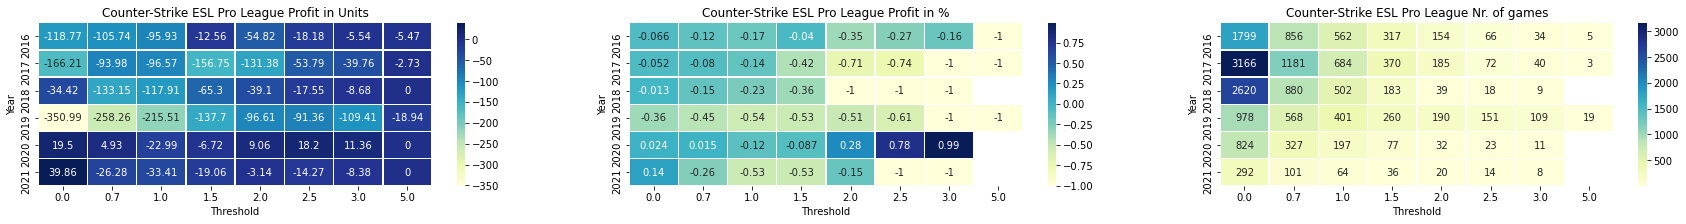

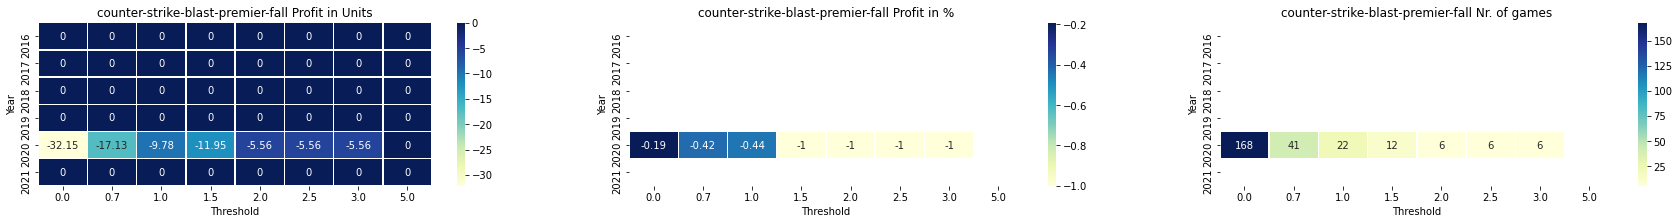

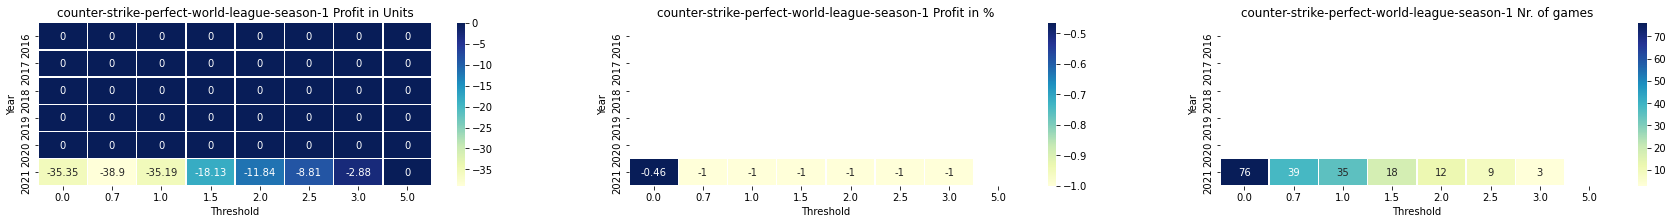

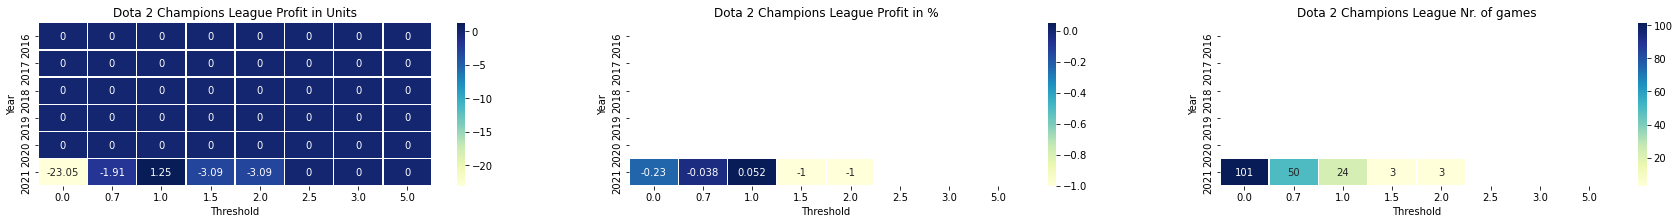

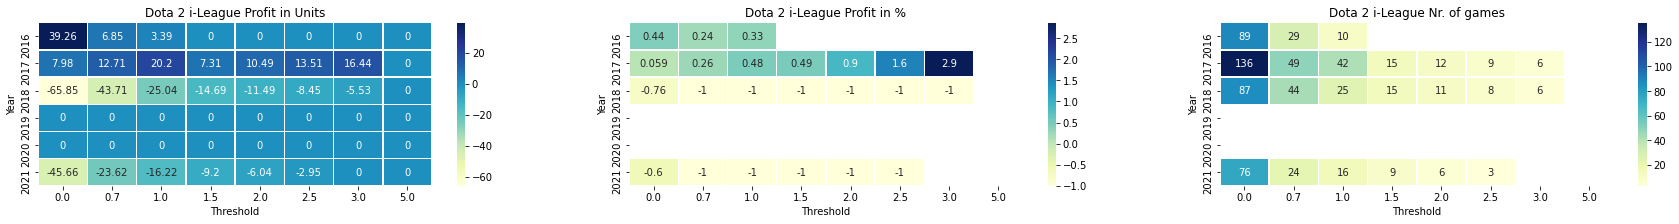

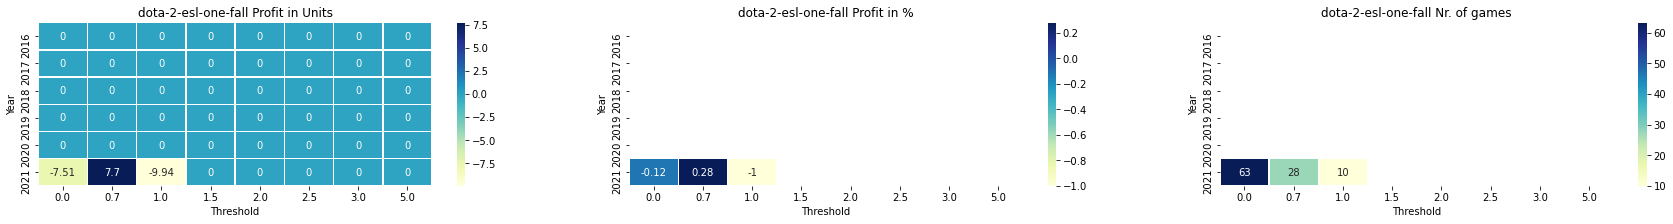

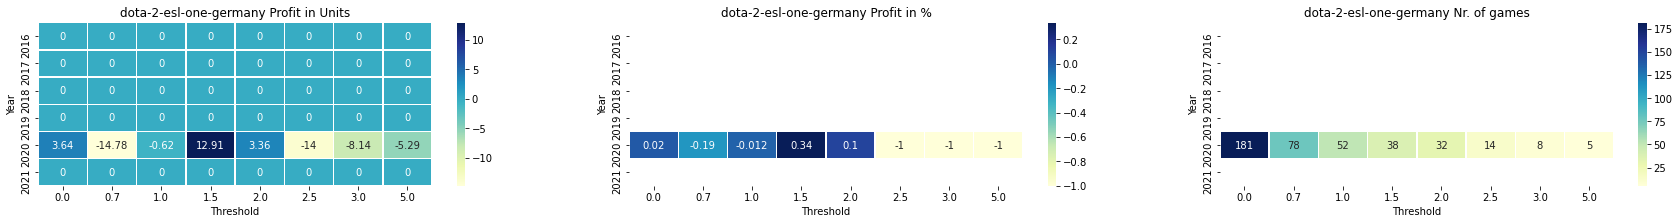

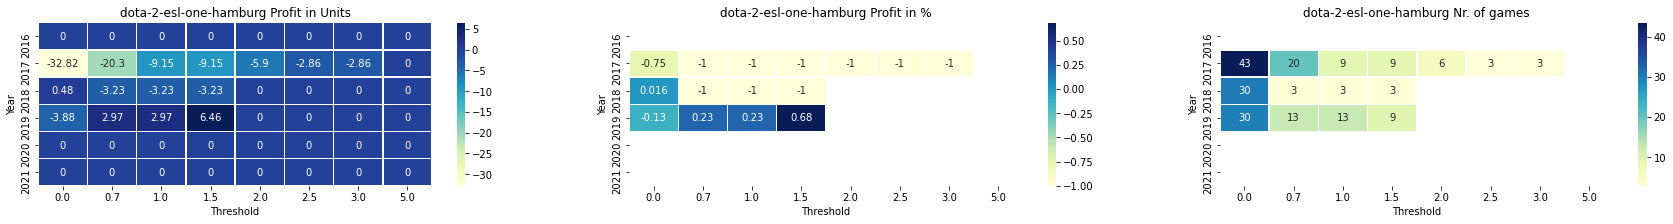

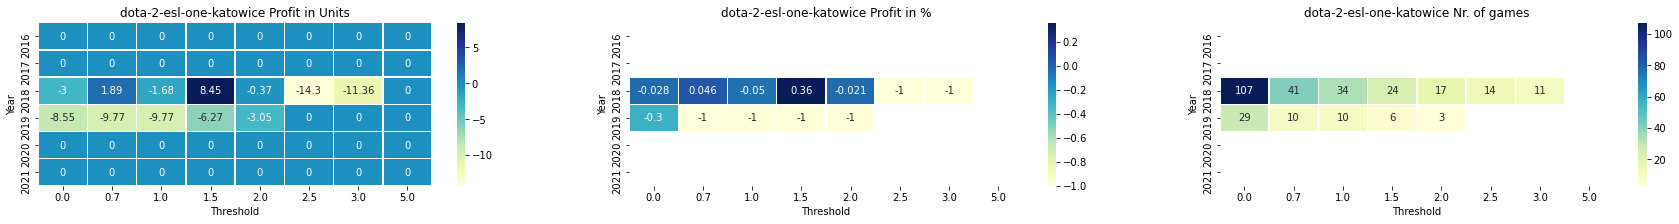

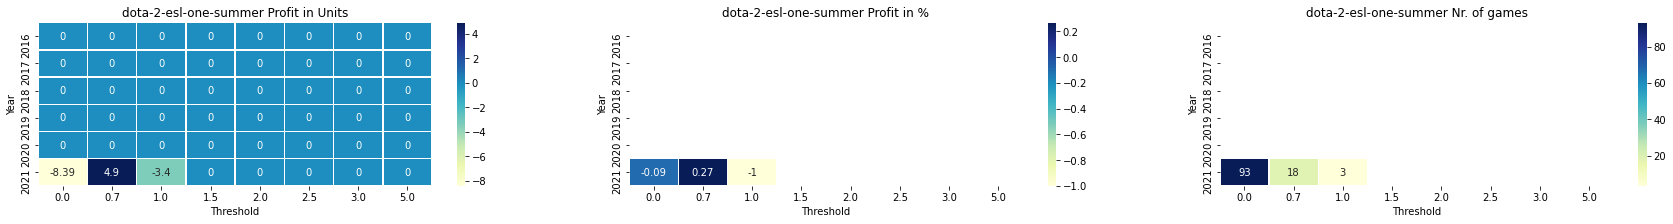

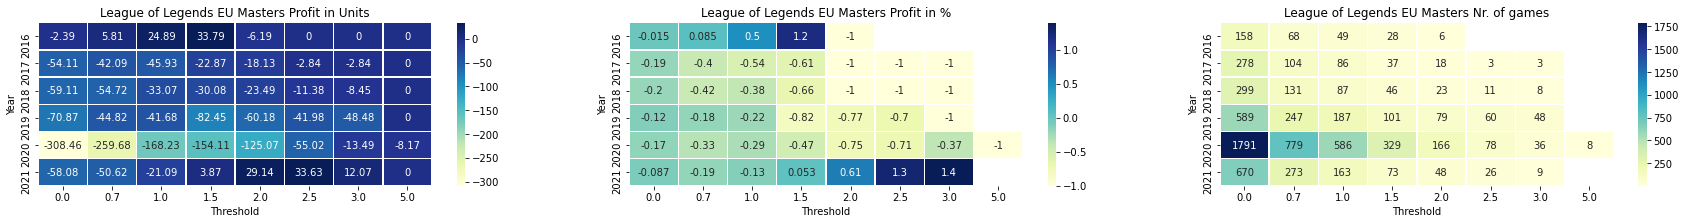

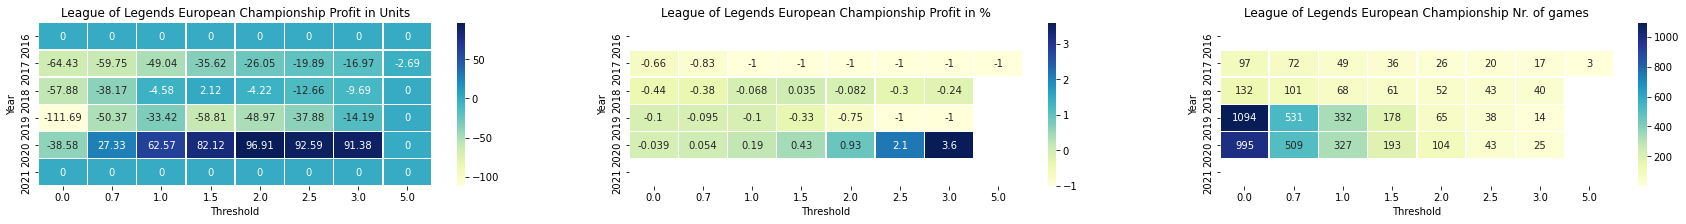

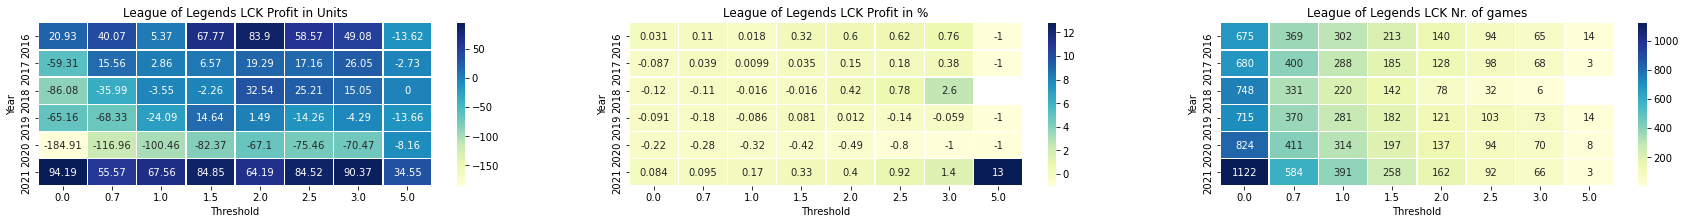

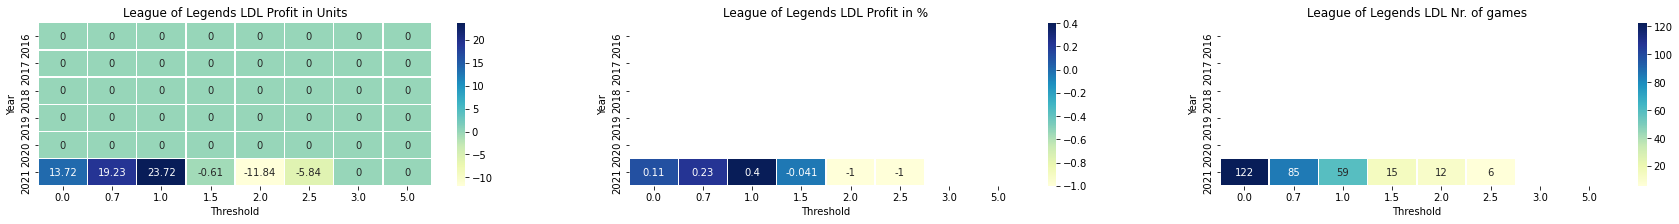

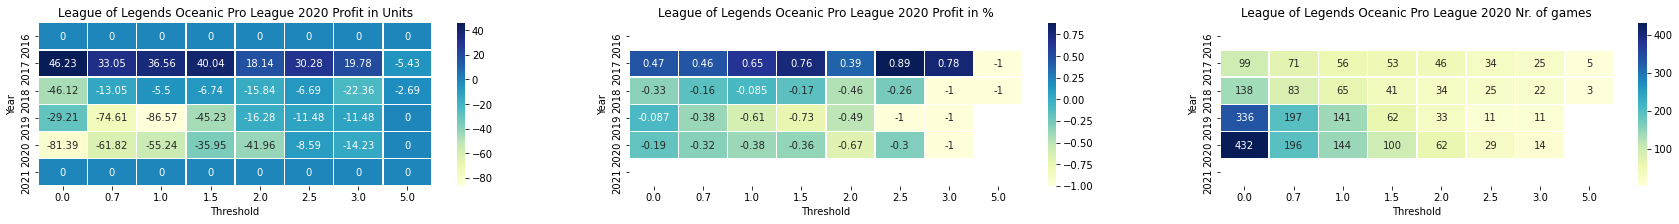

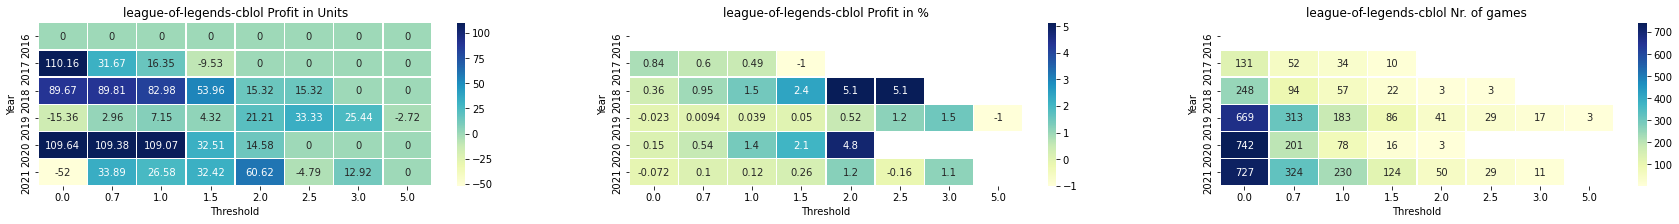

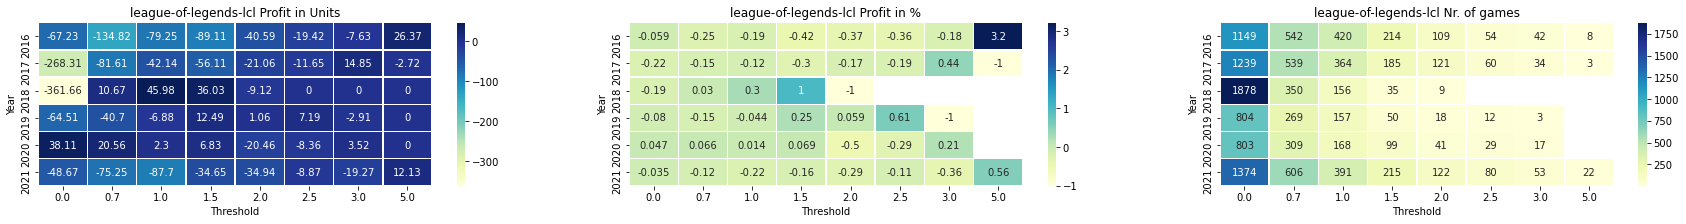

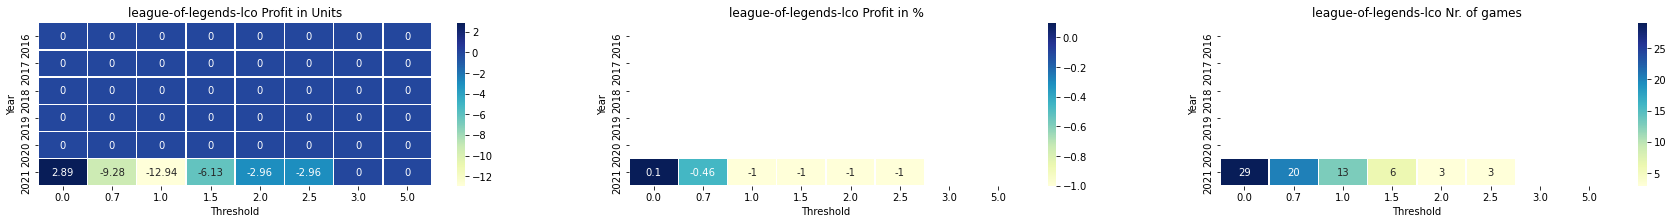

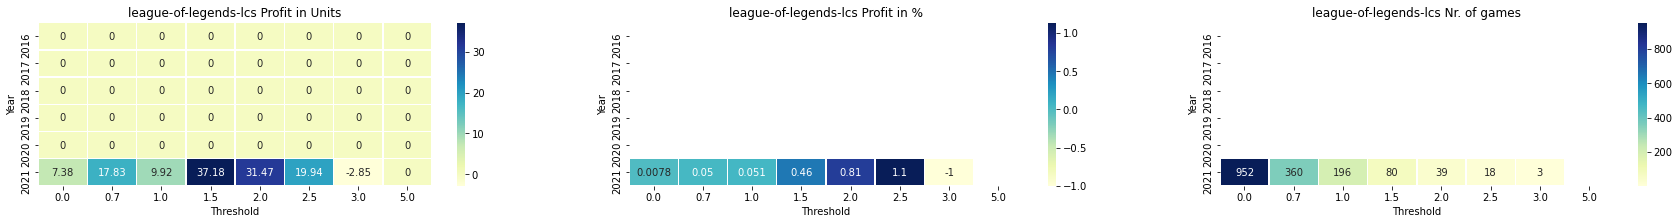

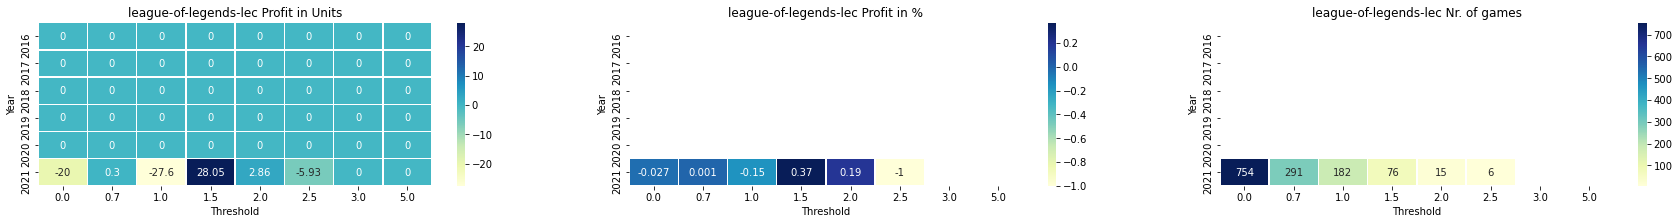

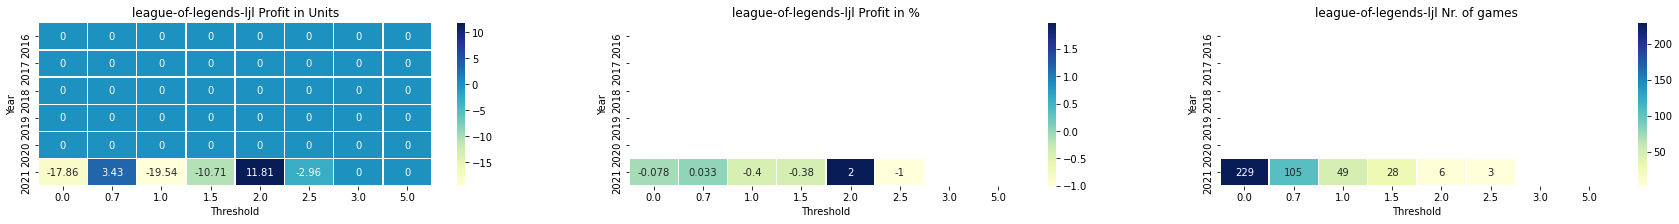

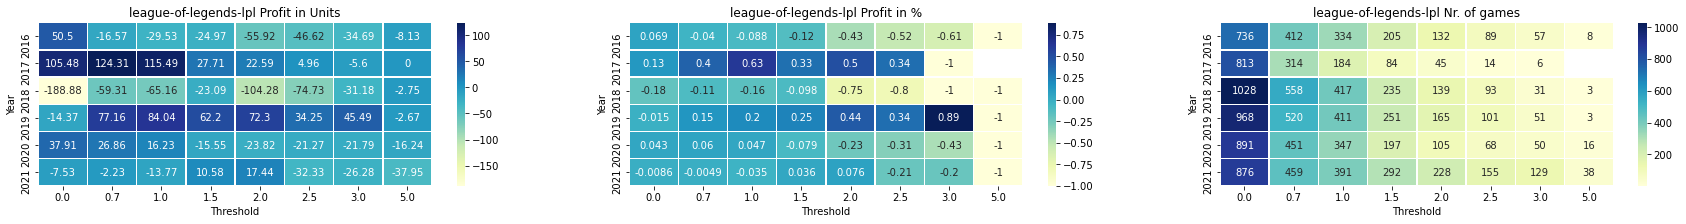

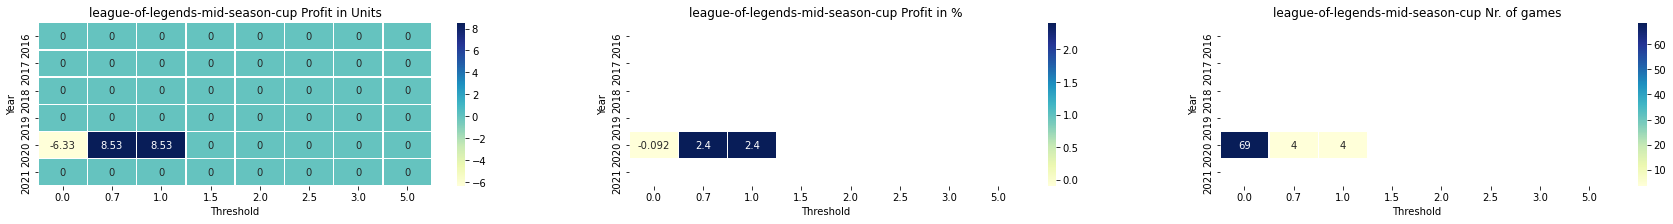

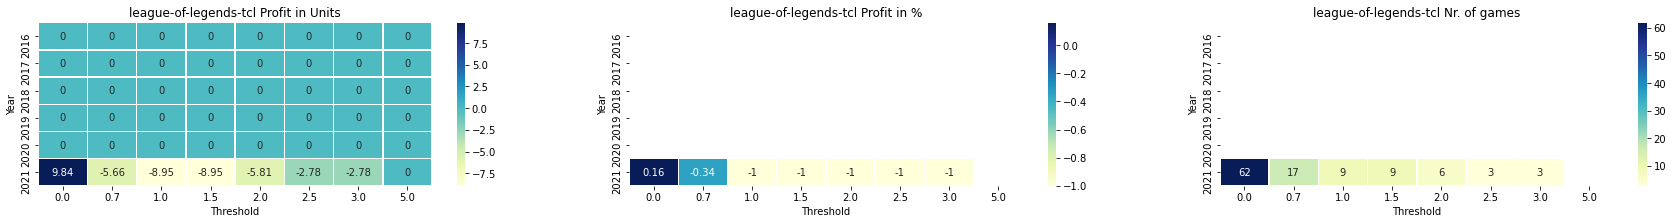

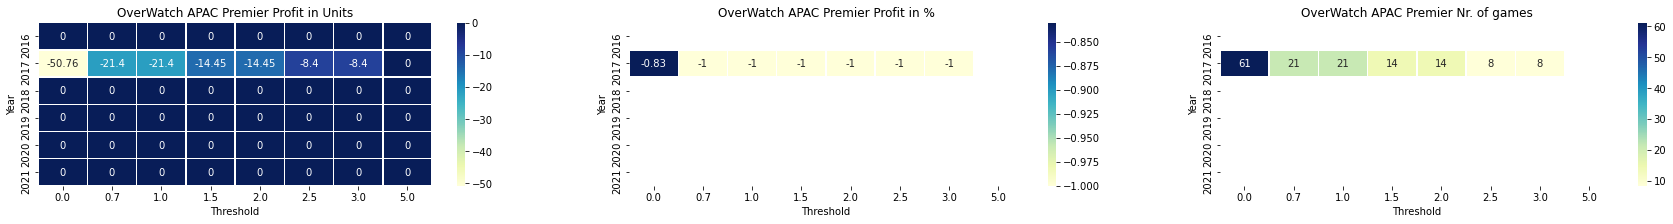

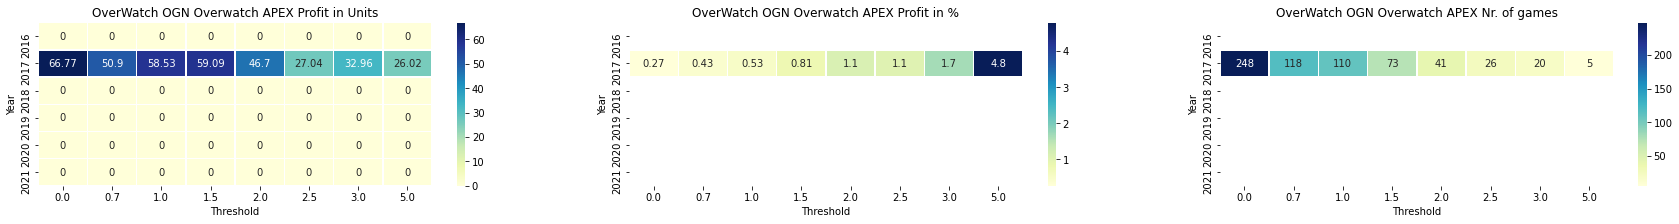

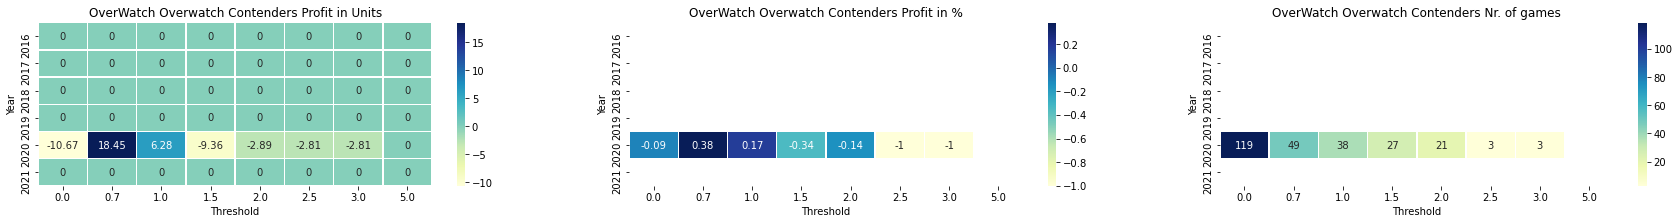

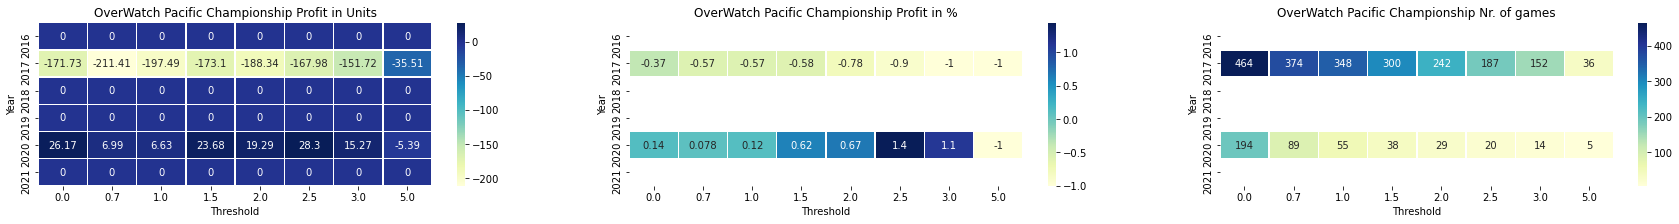

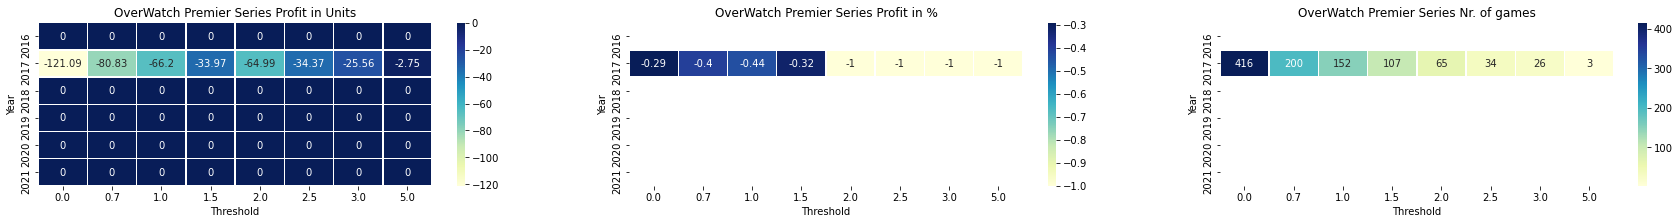

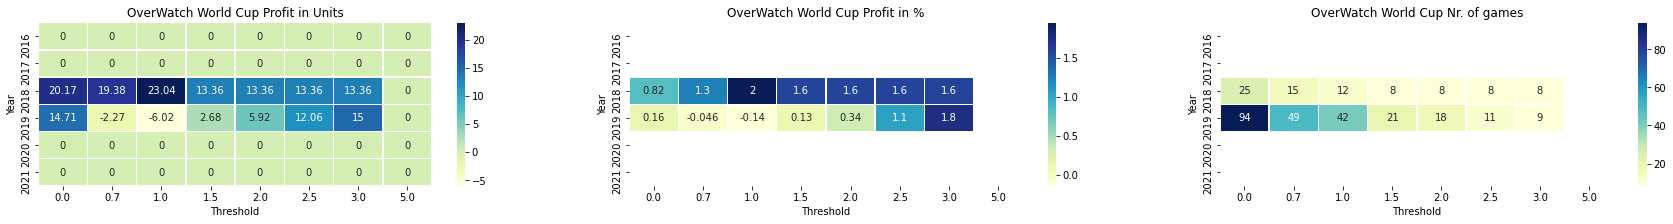

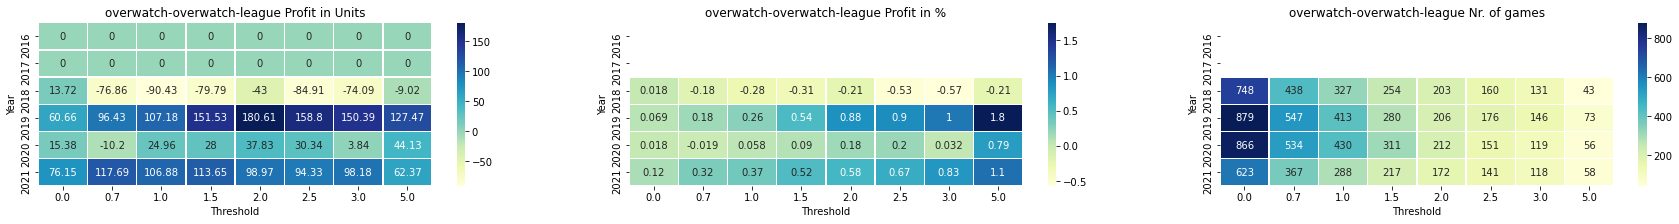

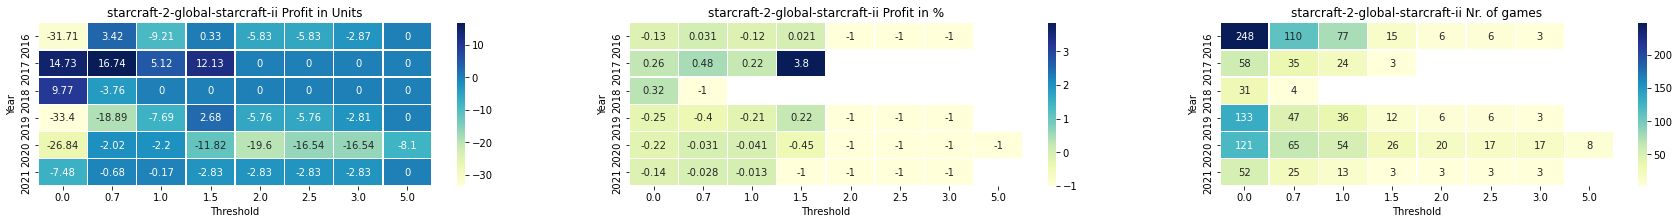

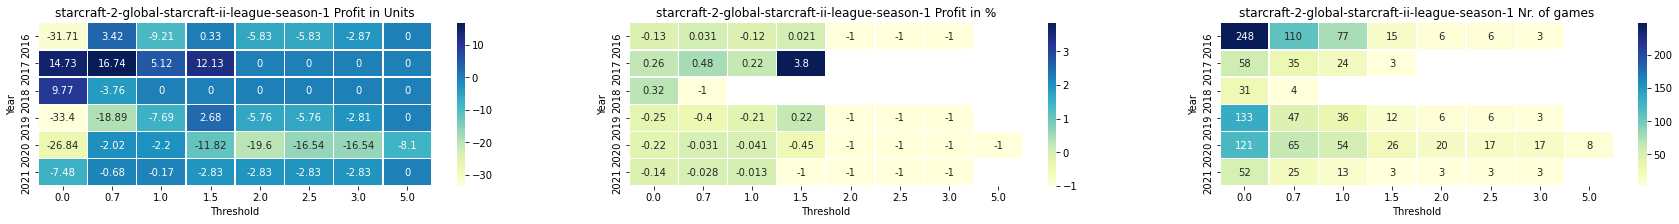

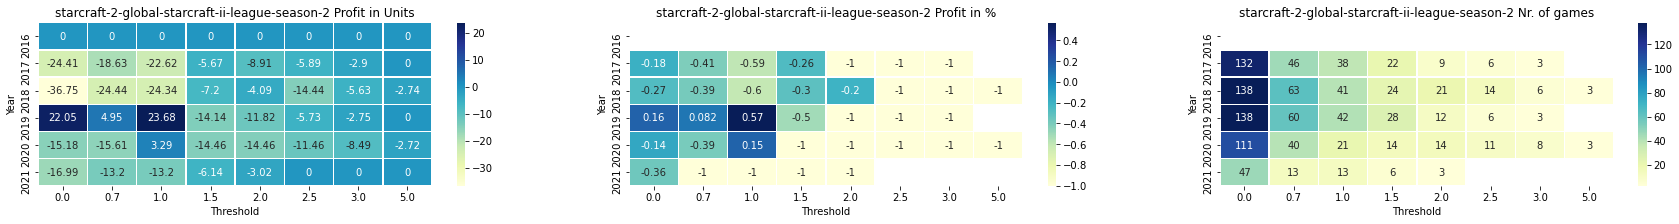

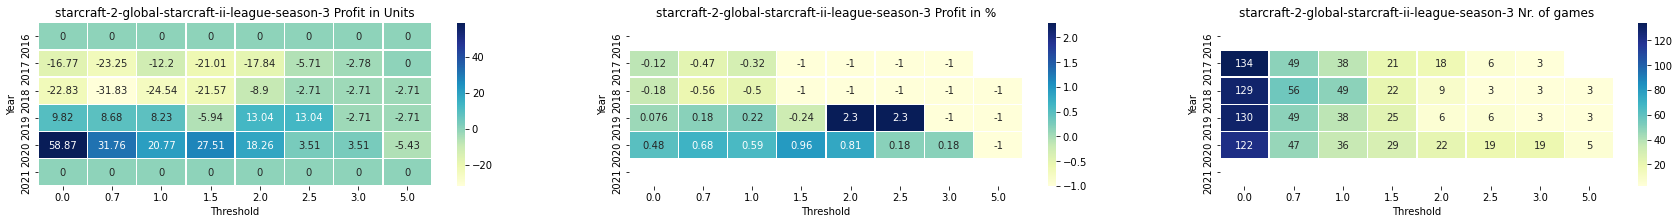

In [14]:
# This plots heatmaps for each league which shows the profit in units (like Euro) and % and the number of games for each year.
# Empty cells or 0 means there is no data for the league and year

i = 0
plt.rcParams["figure.figsize"] = (30,3)

for league in leagues:
    df_results = pd.DataFrame(columns=["Year", "Div", "Threshold", "ProfitOnBig", "Profit_pct", "Profit_cnt"])
    i += 1
    for years in range(2016, 2022): # plots for the years 2016 - 2021
        div = (df["Div"] == league)
        year = (df["Year"] == years)
        i += 1
        for threshold in thresholds:
            std_range = (df["STD"] >= threshold)
            df_filtered = df[year & div & std_range]
            profit = df_filtered["ProfitOnBig"].sum()
            profit_pct = profit / df_filtered["StakeBig"].sum()
            profit_cnt = df_filtered["ProfitOnBig"].sum()/profit_pct
            new_row = pd.Series({"Year":years, "Div":league, "Threshold":threshold, "Profit":round(profit,2), "Profit_pct":profit_pct, "Profit_cnt":profit_cnt})
            df_results = df_results.append(new_row, ignore_index=True)
            i += 1
    fig, ax = plt.subplots(1,3)
    sns.heatmap(df_results.pivot("Year", "Threshold", "Profit"), cmap="YlGnBu", annot=True, fmt="g", linewidths=0.5, ax=ax[0]).set(title=str(league) + " Profit in Units")
    sns.heatmap(df_results.pivot("Year", "Threshold", "Profit_pct"), cmap="YlGnBu", annot=True, linewidths=0.5, ax=ax[1]).set(title=str(league) + " Profit in %")
    sns.heatmap(df_results.pivot("Year", "Threshold", "Profit_cnt"), cmap="YlGnBu", annot=True, fmt=".0f", linewidths=0.5, ax=ax[2]).set(title=str(league) + " Nr. of games")
    fig.show()
    

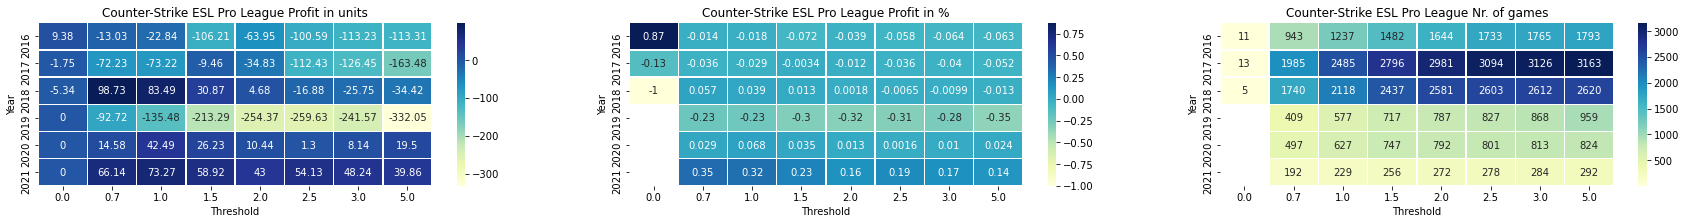

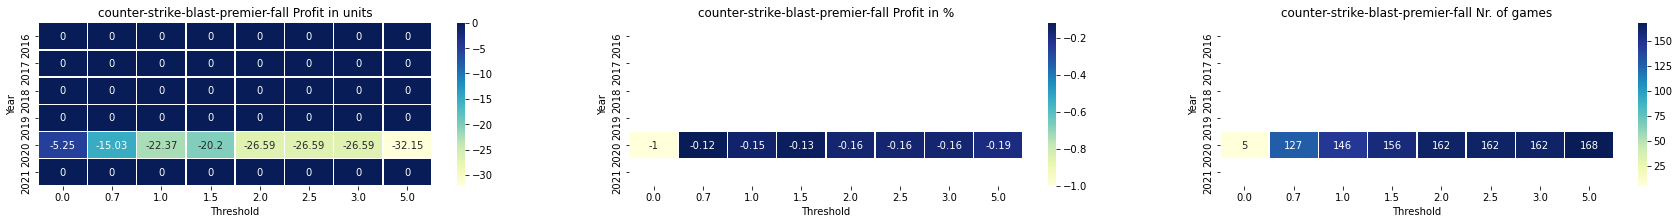

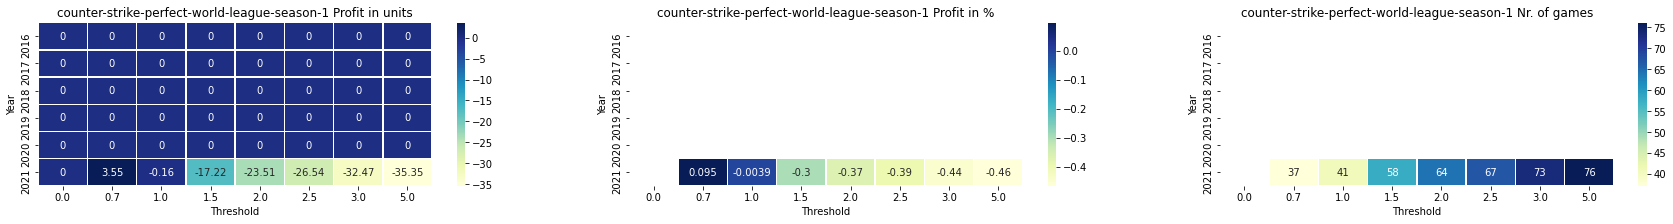

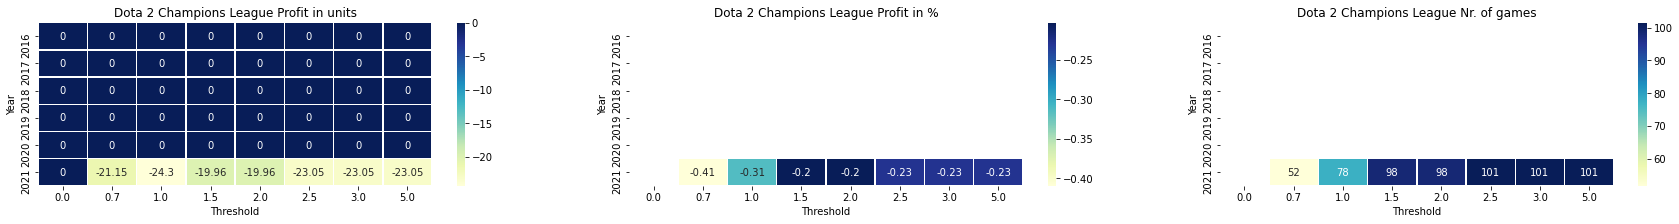

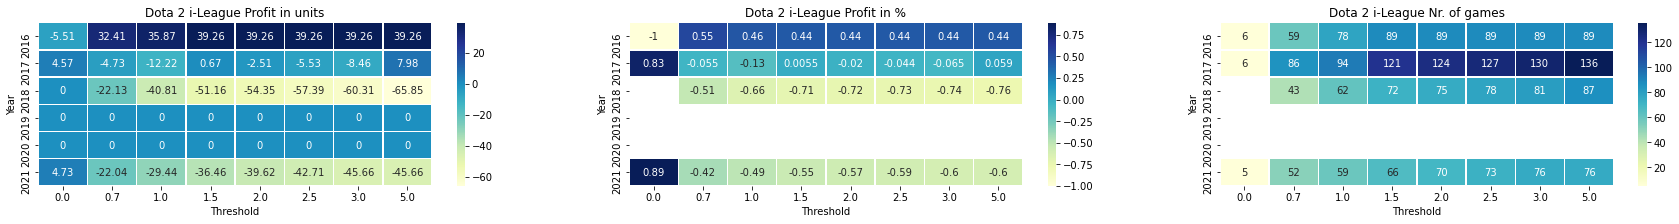

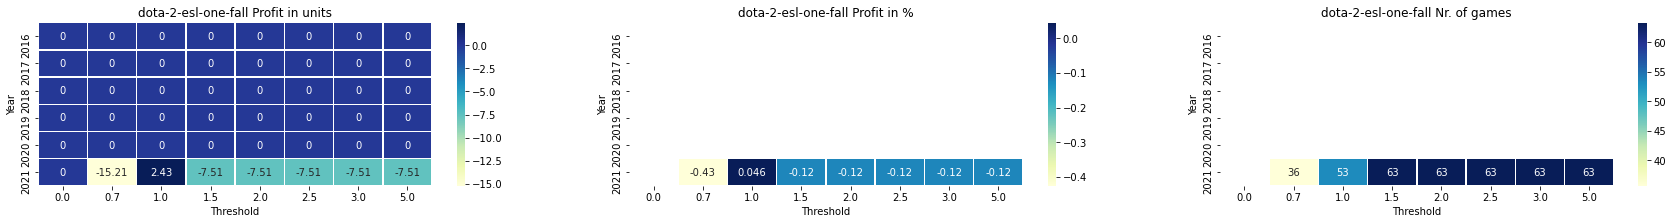

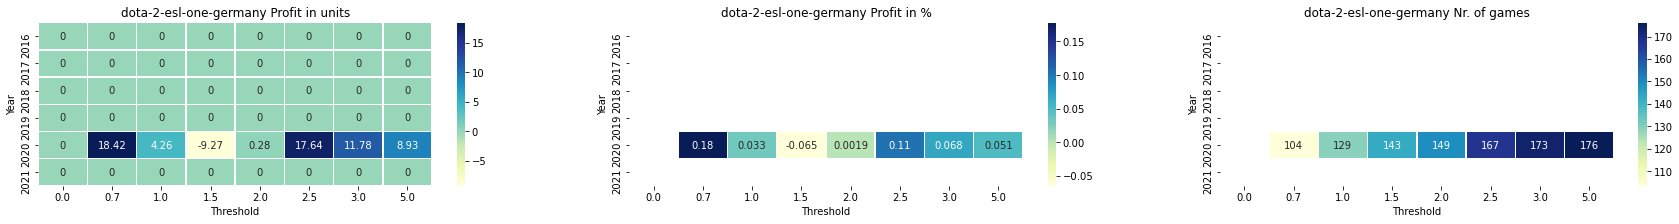

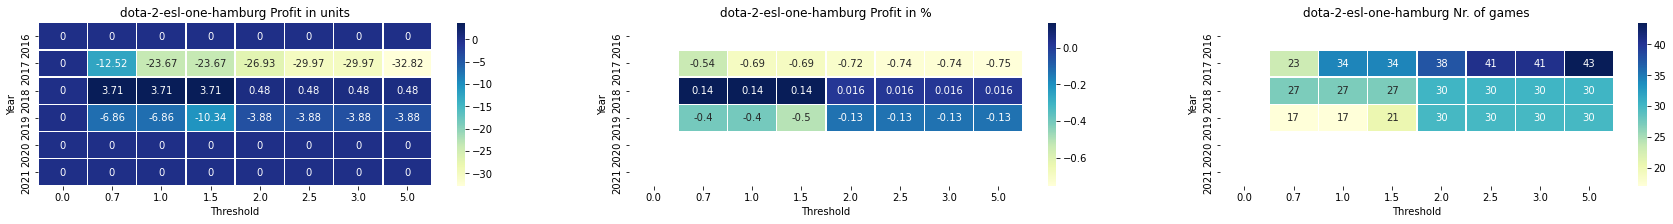

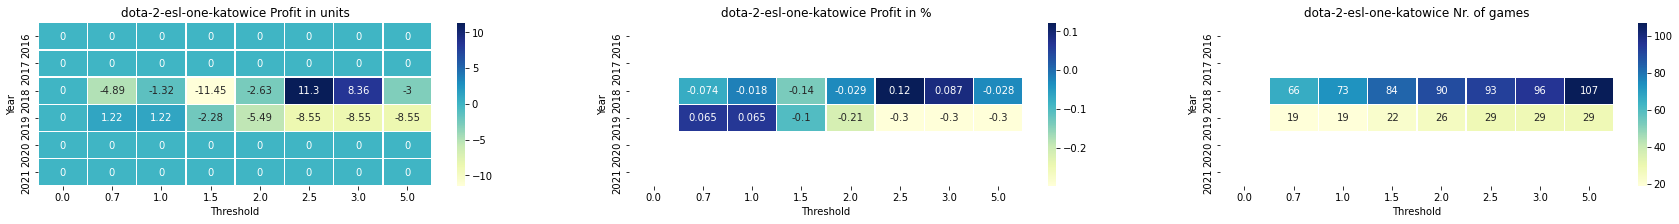

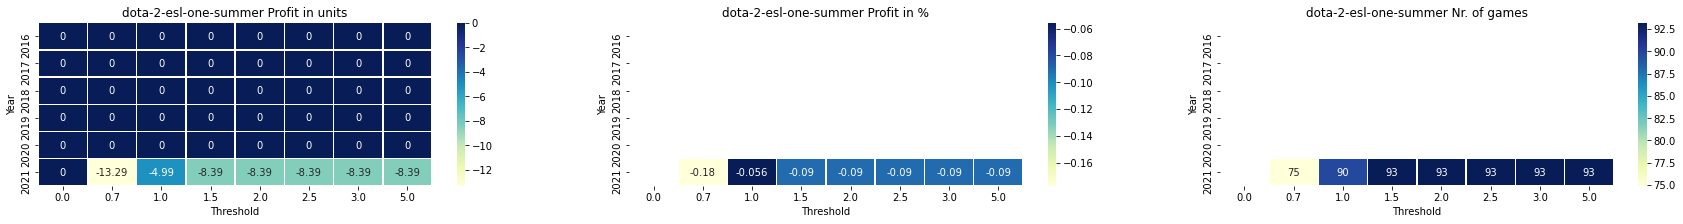

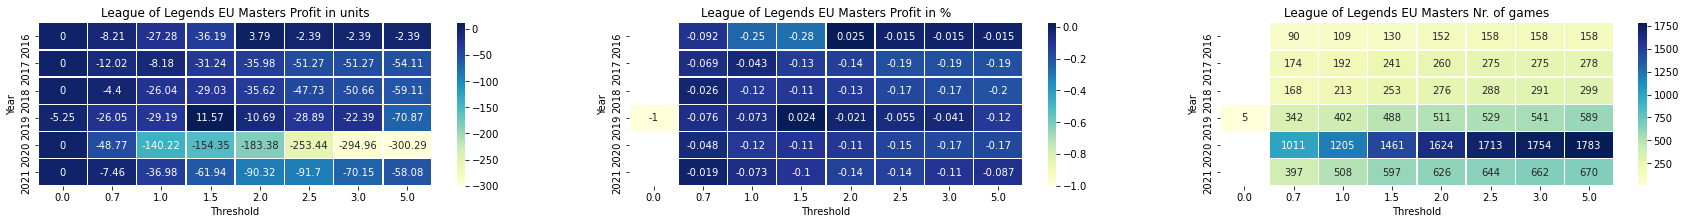

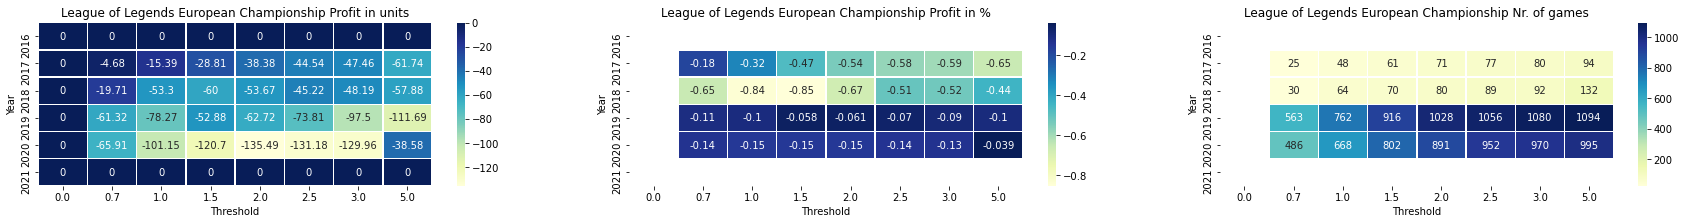

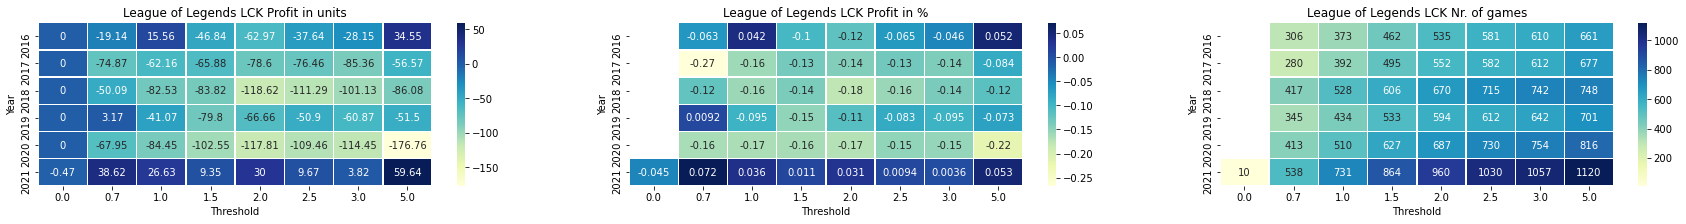

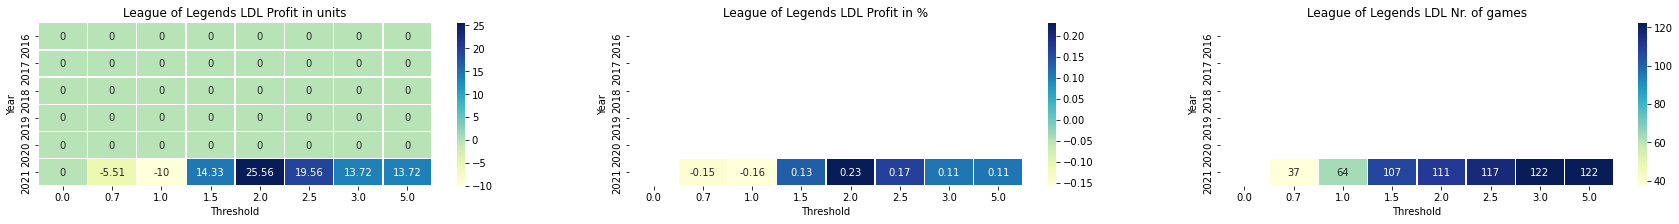

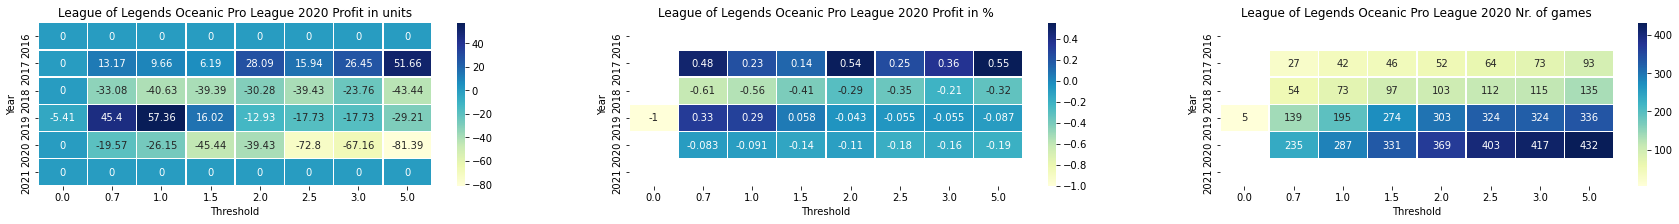

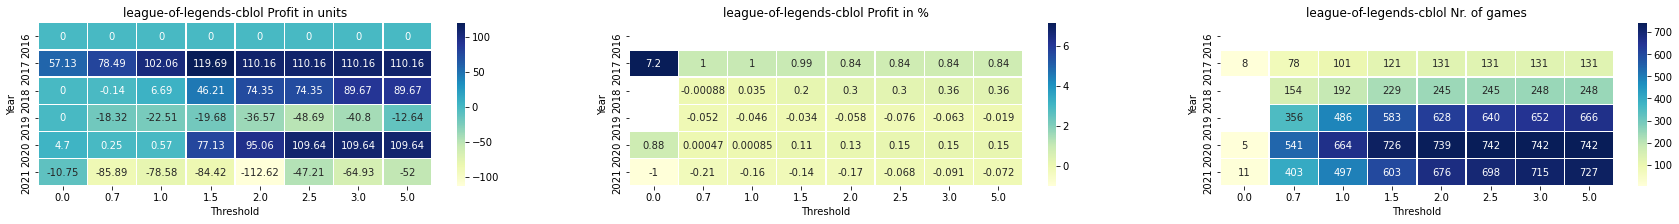

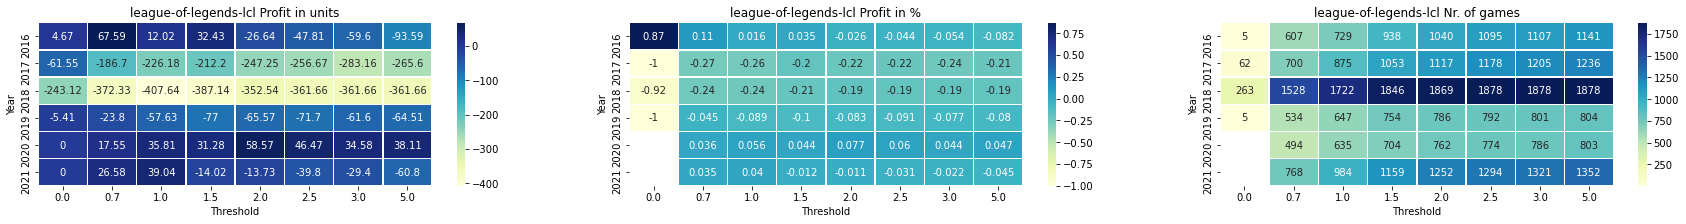

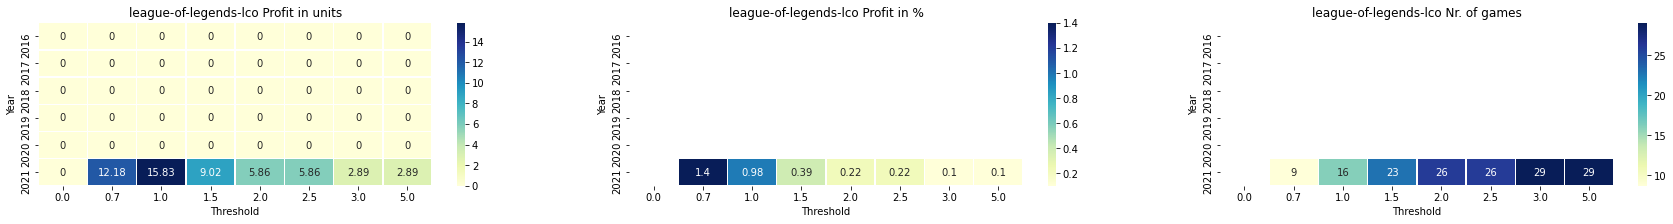

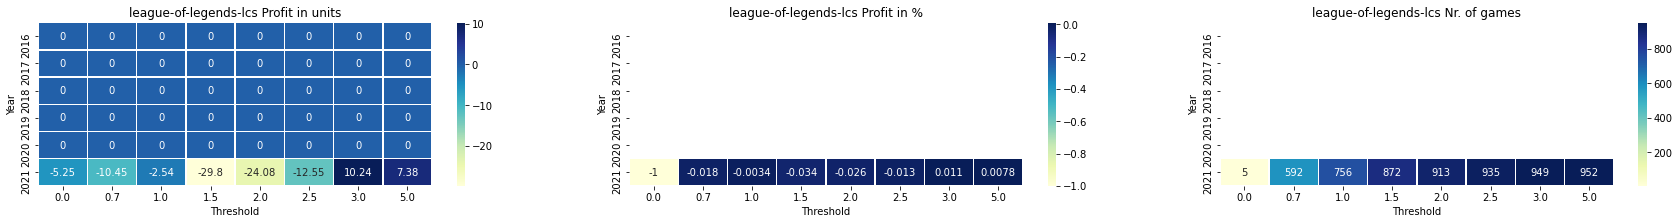

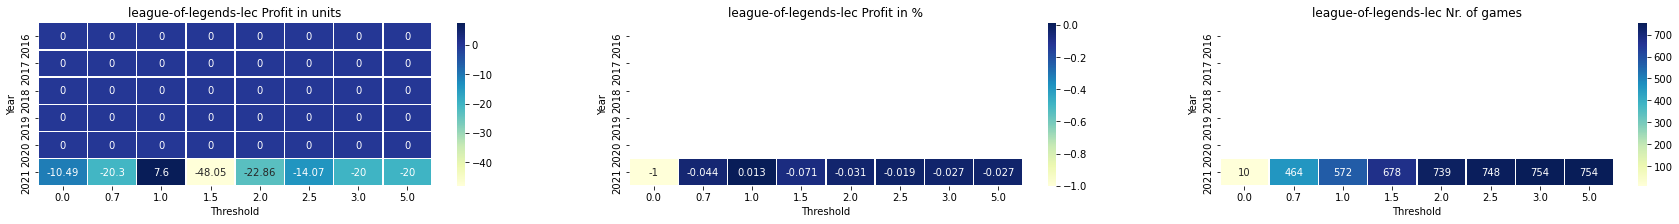

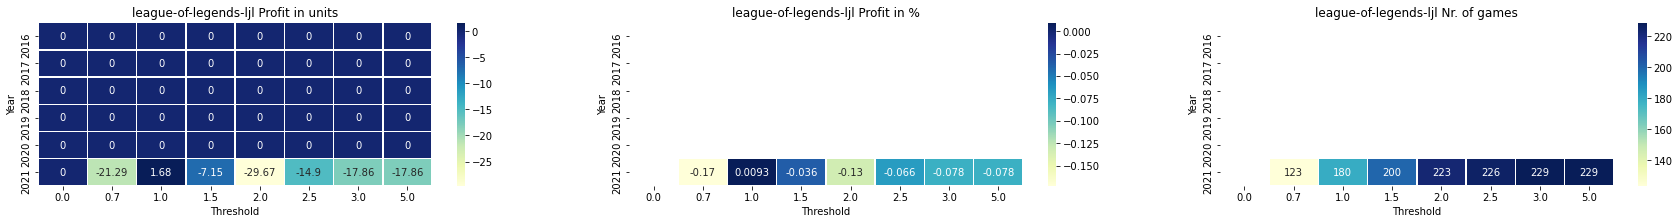

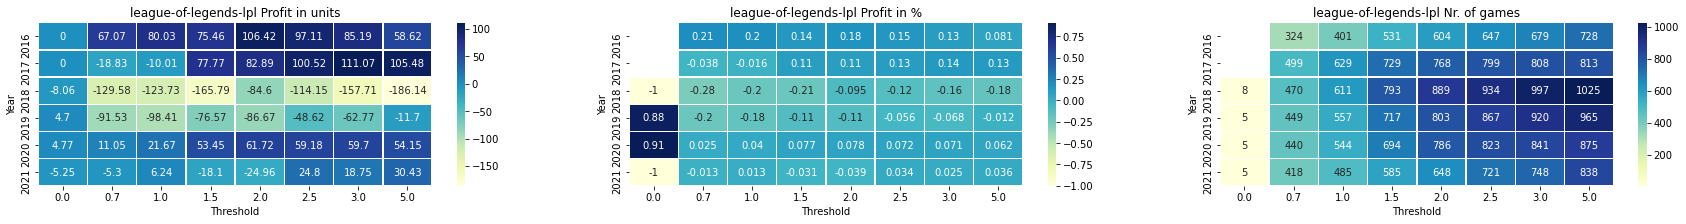

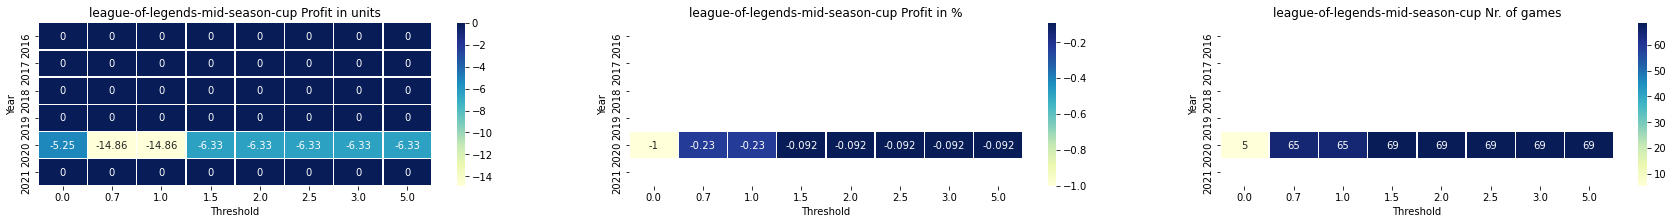

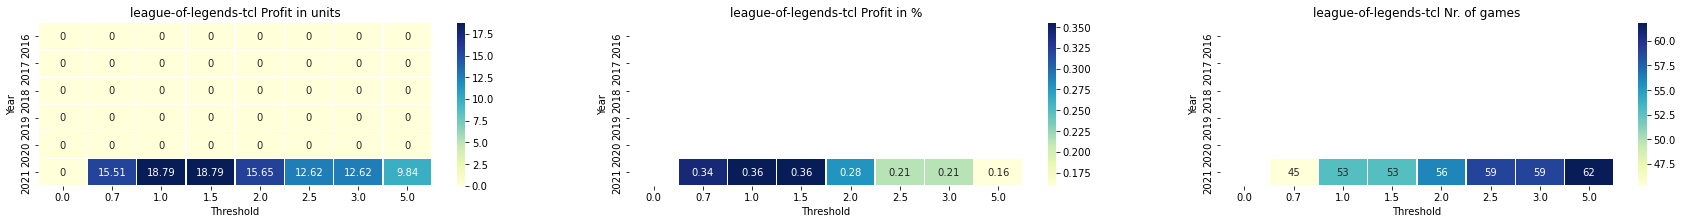

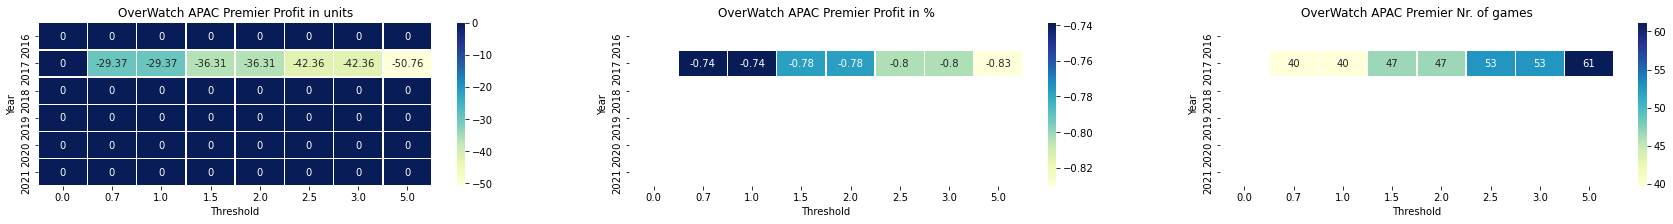

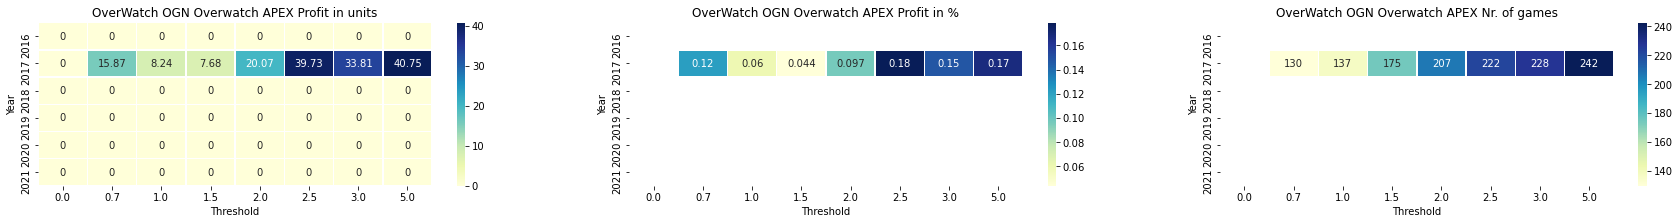

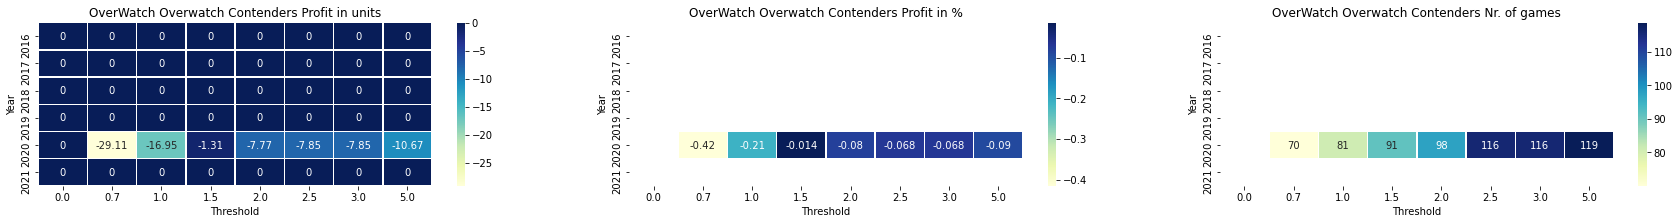

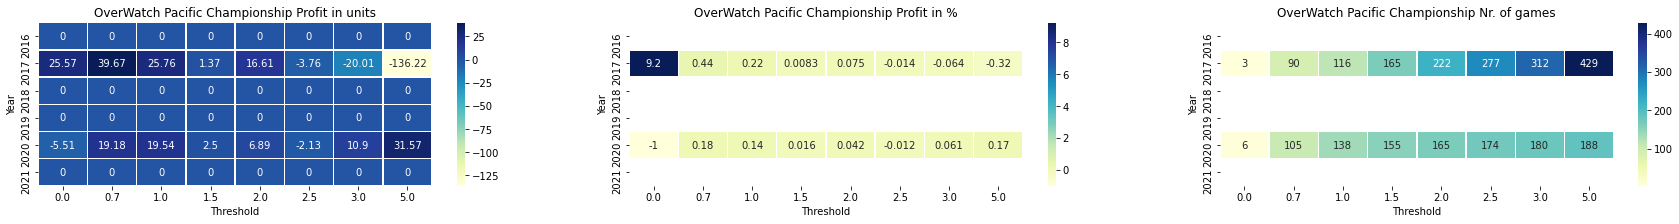

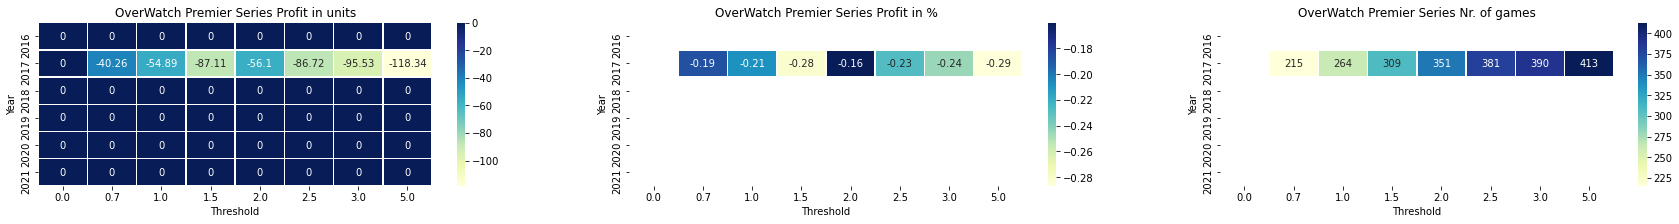

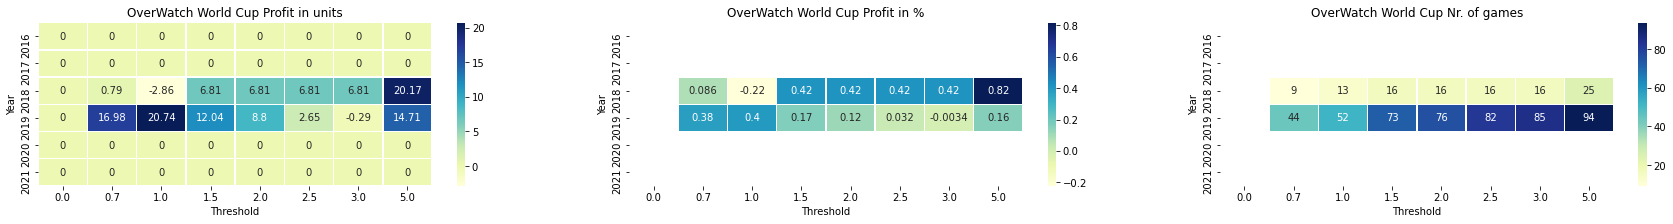

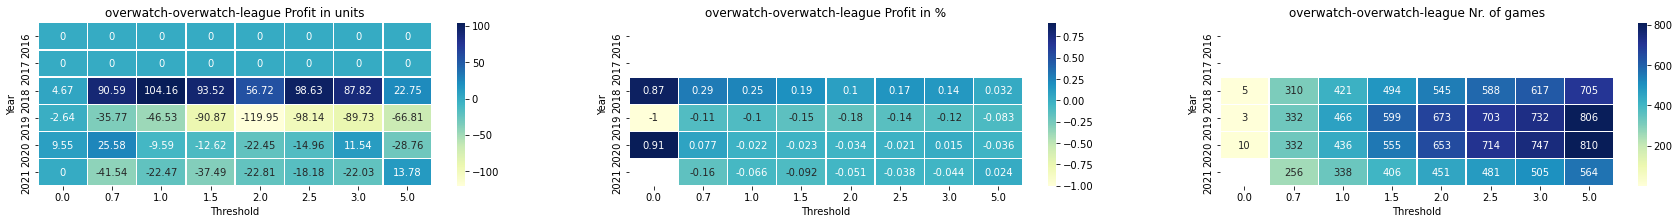

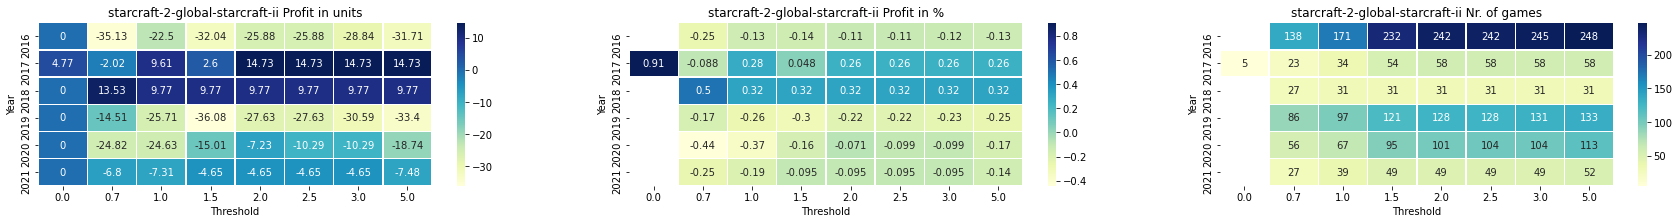

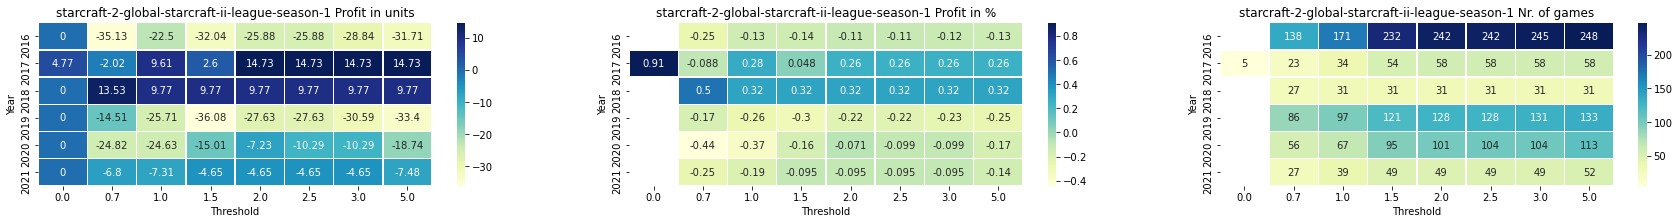

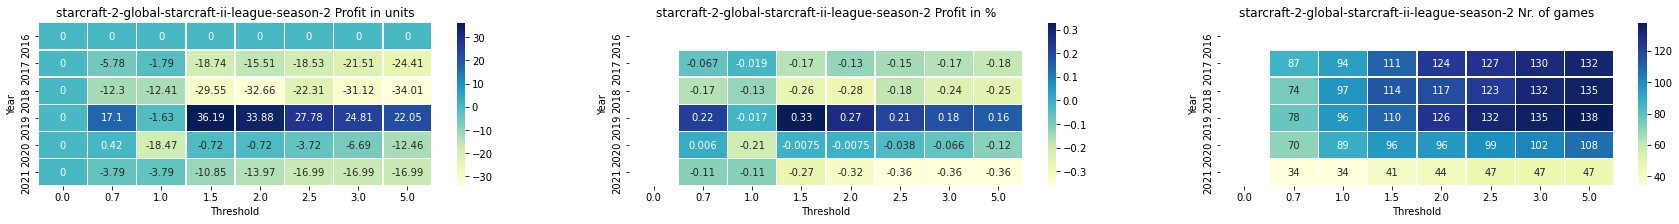

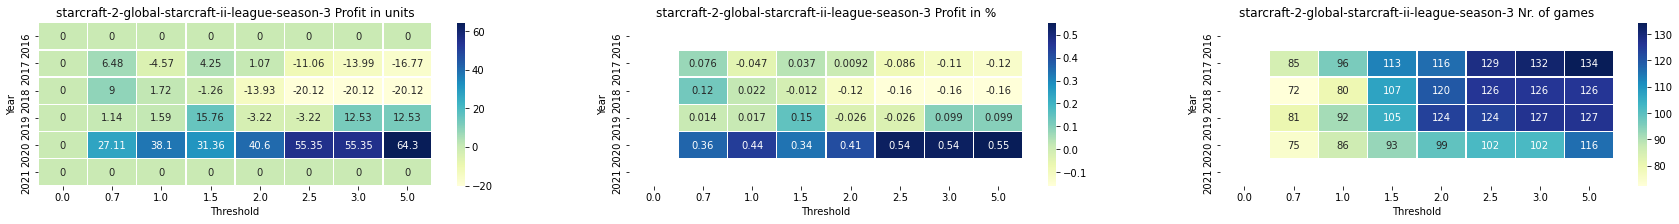

In [15]:
# Same as above but with smaller than threshold

i = 0
plt.rcParams["figure.figsize"] = (30,3)

for league in leagues:
    df_results = pd.DataFrame(columns=["Year", "Div", "Threshold", "ProfitOnBig", "Profit_pct", "Profit_cnt"])
    i += 1
    for years in range(2016, 2022):
        div = (df["Div"] == league)
        year = (df["Year"] == years)
        i += 1
        for threshold in thresholds:
            std_range = (df["STD"] <= threshold)
            df_filtered = df[year & div & std_range]
            profit = df_filtered["ProfitOnBig"].sum()
            profit_pct = df_filtered["ProfitOnBig"].sum() / df_filtered["StakeBig"].sum()
            profit_cnt = df_filtered["ProfitOnBig"].sum() / profit_pct
            new_row = pd.Series({"Year":years, "Div":league, "Threshold":threshold, "Profit":round(profit,2), "Profit_pct":profit_pct, "Profit_cnt":profit_cnt})
            df_results = df_results.append(new_row, ignore_index=True)
            i += 1
    fig, ax = plt.subplots(1,3)
    sns.heatmap(df_results.pivot("Year", "Threshold", "Profit"), cmap="YlGnBu", annot=True, fmt="g", linewidths=0.5, ax=ax[0]).set(title=str(league) + " Profit in units")
    sns.heatmap(df_results.pivot("Year", "Threshold", "Profit_pct"), cmap="YlGnBu", annot=True, linewidths=0.5, ax=ax[1]).set(title=str(league) + " Profit in %")
    sns.heatmap(df_results.pivot("Year", "Threshold", "Profit_cnt"), cmap="YlGnBu", annot=True, fmt=".0f", linewidths=0.5, ax=ax[2]).set(title=str(league) + " Nr. of games")
    fig.show()

### Filter by Game & | Date

In [35]:
# Filter by game xy and get results for all xy-matches combined

game = "starcraft-2-global-starcraft-ii-league-season"
df = df[df["Div"].str.contains(game)]

In [ ]:
# Filter by date

#df = df[df['Date'] > "2021-04-01"]

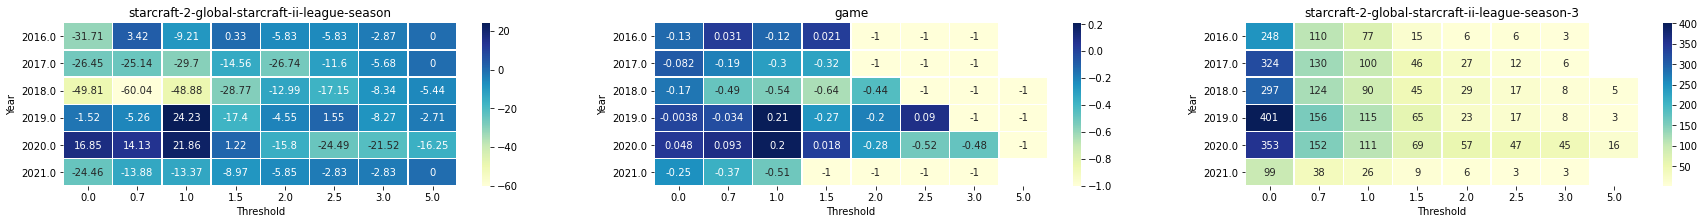

In [36]:
# Plots heatmaps for all xy game matches:

i = 0
plt.rcParams["figure.figsize"] = (30,3)

for _ in [_]:
    df_results = pd.DataFrame(columns=["Date", "Threshold", "ProfitOnBig", "Profit_pct", "Profit_cnt"])
    i += 1
    for years in range(2016, 2022):
        year = (df["Year"] == years)
        i += 1
        for threshold in thresholds:
            std_range = (df["STD"] >= threshold)
            df_filtered = df[year & std_range]
            profit = df_filtered["ProfitOnBig"].sum()
            profit_pct = df_filtered["ProfitOnBig"].sum() / df_filtered["StakeBig"].sum()
            profit_cnt = df_filtered["ProfitOnBig"].sum() / profit_pct
            new_row = pd.Series({"Year":years, "Threshold":threshold, "Profit":round(profit,2), "Profit_pct":profit_pct, "Profit_cnt":profit_cnt})
            df_results = df_results.append(new_row, ignore_index=True)
            i += 1
    fig, ax = plt.subplots(1,3)
    sns.heatmap(df_results.pivot("Year", "Threshold", "Profit"), cmap="YlGnBu", annot=True, fmt="g", linewidths=0.5, ax=ax[0]).set(title=game)
    sns.heatmap(df_results.pivot("Year", "Threshold", "Profit_pct"), cmap="YlGnBu", annot=True, linewidths=0.5, ax=ax[1]).set(title=game)
    sns.heatmap(df_results.pivot("Year", "Threshold", "Profit_cnt"), cmap="YlGnBu", annot=True, fmt=".0f", linewidths=0.5, ax=ax[2]).set(title=league)
    fig.show()
    

Please note: this is all fun and games and math but no advice on how to bet. Please do your own research.